## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [3]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

In [4]:
import os
os.chdir("/home/brash/Phys421/WWO")
df1 = pd.read_csv('regina.csv')
df2 = pd.read_csv('regina_2018.csv')
df3 = pd.read_csv('regina_2017.csv')

In [5]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.
#
# The factor 8*N takes into account that the data in our dataframe
# is reported once every three hours (or 8 times per day)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*8*N + [df[feature][i-8*N] for i in range(8*N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [6]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [7]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df1, feature, N)
            derive_nth_day_feature(df2, feature, N)
            derive_nth_day_feature(df3, feature, N)

In [8]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df1.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,6.320548,-1.304110,0.096986,9.662740,2.778082,45.084932,-2.838014,-0.770548,2.878082,-0.827740,...,9.672928,15.394574,15.407369,15.426796,208.945398,208.695592,208.353591,0.246291,0.246970,0.247652
std,15.216829,13.729361,0.388413,4.160689,1.682609,31.265919,12.333195,17.486786,14.668713,17.401909,...,4.176386,6.757152,6.760687,6.759334,94.242035,94.249179,94.153133,1.124402,1.125876,1.127356
min,-28.000000,-36.000000,0.000000,3.000000,1.000000,0.000000,-40.000000,-46.000000,-36.000000,-46.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-6.000000,-12.000000,0.000000,5.900000,1.000000,17.000000,-10.000000,-14.000000,-8.000000,-14.000000,...,5.900000,10.000000,10.000000,10.000000,130.000000,129.000000,129.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,9.200000,2.000000,44.000000,-2.000000,1.000000,4.000000,1.000000,...,9.300000,14.000000,14.000000,14.000000,217.000000,216.500000,216.000000,0.000000,0.000000,0.000000
75%,20.000000,11.000000,0.000000,13.500000,4.000000,72.000000,7.000000,14.000000,15.000000,14.000000,...,13.500000,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000
max,32.000000,21.000000,3.400000,16.700000,7.000000,100.000000,19.000000,33.000000,33.000000,31.000000,...,16.700000,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000


In [9]:
df2.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,7.824658,-0.356164,0.069041,10.023836,2.969863,46.734247,-2.088014,0.217808,3.687329,0.176712,...,10.060773,15.223214,15.208678,15.222030,206.478365,206.871212,206.910221,0.054808,0.054855,0.055007
std,14.710897,13.226122,0.403412,4.281772,1.898174,31.277963,10.512825,17.124911,14.409367,17.075983,...,4.275437,7.548558,7.552858,7.556585,94.994980,94.821063,94.883997,0.474435,0.475059,0.475706
min,-23.000000,-29.000000,0.000000,3.000000,1.000000,0.000000,-30.000000,-38.000000,-29.000000,-38.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.000000,-11.000000,0.000000,6.700000,1.000000,19.000000,-9.000000,-13.000000,-7.000000,-13.000000,...,6.700000,10.000000,10.000000,10.000000,136.000000,136.000000,136.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000,10.100000,2.000000,46.000000,-2.000000,-1.000000,2.000000,-1.000000,...,10.100000,14.000000,14.000000,14.000000,209.000000,209.000000,209.000000,0.000000,0.000000,0.000000
75%,22.000000,12.000000,0.000000,14.500000,5.000000,74.000000,7.000000,16.000000,16.000000,16.000000,...,14.500000,20.000000,20.000000,20.000000,293.000000,293.000000,294.000000,0.000000,0.000000,0.000000
max,41.000000,23.000000,4.300000,16.700000,8.000000,100.000000,21.000000,41.000000,41.000000,41.000000,...,16.700000,42.000000,42.000000,42.000000,360.000000,360.000000,360.000000,13.500000,13.500000,13.500000


In [10]:
df3.describe

<bound method NDFrame.describe of                 date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0     2017-01-01 00:00:00       -14       -19           0.0      6.9        1   
1     2017-01-01 03:00:00       -14       -19           0.0      6.9        1   
2     2017-01-01 06:00:00       -14       -19           0.0      6.9        1   
3     2017-01-01 09:00:00       -14       -19           0.0      6.9        1   
4     2017-01-01 12:00:00       -14       -19           0.0      6.9        1   
...                   ...       ...       ...           ...      ...      ...   
2915  2017-12-31 09:00:00       -23       -29           0.0      3.2        1   
2916  2017-12-31 12:00:00       -23       -29           0.0      3.2        1   
2917  2017-12-31 15:00:00       -23       -29           0.0      3.2        1   
2918  2017-12-31 18:00:00       -23       -29           0.0      3.2        1   
2919  2017-12-31 21:00:00       -23       -29           0.0      3.2       

In [11]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df1.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df1 = df1[to_keep]
df2 = df2[to_keep]
df3 = df3[to_keep]

['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


In [12]:
df1.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
0,2019-01-01 00:00:00,-12,-26,-28,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 03:00:00,-12,-26,-28,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 06:00:00,-12,-26,-27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 09:00:00,-12,-26,-24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 12:00:00,-12,-26,-18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# the last task is to convert the date_time column from an object into a floating point number
# there are a number of ways that we could do this

df1['date'] = pd.to_datetime(df1['date_time'])    
df1['date_delta'] = (df1['date'] - df1['date'].min())  / np.timedelta64(1,'D')

df2['date'] = pd.to_datetime(df2['date_time'])    
df2['date_delta'] = (df2['date'] - df2['date'].min())  / np.timedelta64(1,'D')

df3['date'] = pd.to_datetime(df3['date_time'])    
df3['date_delta'] = (df3['date'] - df3['date'].min())  / np.timedelta64(1,'D')


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [14]:
df2.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date,date_delta
0,2018-01-01 00:00:00,-20,-26,-26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,0.000
1,2018-01-01 03:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 03:00:00,0.125
2,2018-01-01 06:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 06:00:00,0.250
3,2018-01-01 09:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 09:00:00,0.375
4,2018-01-01 12:00:00,-20,-26,-22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 12:00:00,0.500


In [15]:
# Now, let's get rid of the rows that do not have complete data!

df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()

## We are now ready to do a linear regression fit to the data!!

In [16]:
# for our model, we will only include variables where the abs(r) > 0.4 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_1', 
              'mintempC_1',   'tempC_2',   'DewPointC_2',
              'maxtempC_2', 'mintempC_2', 'tempC_3',
              'DewPointC_3',  'mintempC_3',  'maxtempC_3',
              'pressure_1',  'pressure_2',  'pressure_3',
              'humidity_1',   'humidity_2', 'humidity_3',
              'sunHour_1', 'sunHour_2', 'sunHour_3']
df12 = df1[['date_delta']+['tempC'] + predictors]
df22 = df2[['date_delta']+['tempC'] + predictors]
df32 = df3[['date_delta']+['tempC'] + predictors]

In [17]:
# separate our my predictor variables (X) from my outcome variable y
Xtrain = df12[predictors+['date_delta']]
ytrain = df12['tempC']
Xtest = df22[predictors+['date_delta']]
ytest = df22['tempC']
Xval = df32[predictors+['date_delta']]
yval = df32['tempC']

## OK, so I lied ... now we are REALLY read to do the linear regression fit!  We had to prepare the data a bit more, didn't we?

In [18]:
print("Training instances   {}, Training features   {}".format(Xtrain.shape[0], Xtrain.shape[1]))
print("Validation instances {}, Validation features {}".format(Xval.shape[0], Xval.shape[1]))
print("Testing instances    {}, Testing features    {}".format(Xtest.shape[0], Xtest.shape[1]))

Training instances   2896, Training features   22
Validation instances 2896, Validation features 22
Testing instances    2896, Testing features    22


In [19]:
import tensorflow as tf

In [20]:
feature_cols = [tf.feature_column.numeric_column(col) for col in Xtrain.columns]

In [21]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [26]:
evaluations = []
STEPS = 400
for i in range(100):
    regressor.train(input_fn=wx_input_fn(Xtrain, y=ytrain), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(Xval,
                                                               yval,
                                                               num_epochs=1,
                                                               shuffle=False)))


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.27943s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:39:51
INFO:tensorflow:Saving dict for global step 800: average_loss = 38.23251, global_step = 800, label/mean = 5.5051794, loss = 41.829052, prediction/mean = 5.23217
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 800: tf_wx_model/model.ckpt-800
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling mod

INFO:tensorflow:global_step/sec: 64.8475
INFO:tensorflow:loss = 29.169283, step = 1700 (1.545 sec)
INFO:tensorflow:global_step/sec: 76.2309
INFO:tensorflow:loss = 27.47795, step = 1800 (1.312 sec)
INFO:tensorflow:global_step/sec: 73.4075
INFO:tensorflow:loss = 21.05759, step = 1900 (1.363 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into tf_wx_model/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:Loss for final step: 23.87153.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just th

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-2800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.28465s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:40:24
INFO:tensorflow:Saving dict for global step 2800: average_loss = 32.286514, global_step = 2800, label/mean = 5.5051794, loss = 34.227406, prediction/mean = 5.3197284
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2800: tf_wx_model/model.ckpt-2800
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you 

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3600...
INFO:tensorflow:loss = 23.01696, step = 3600
INFO:tensorflow:global_step/sec: 72.7228
INFO:tensorflow:loss = 23.599207, step = 3700 (1.377 sec)
INFO:tensorflow:global_step/sec: 81.8943
INFO:tensorflow:loss = 25.027973, step = 3800 (1.221 sec)
INFO:tensorflow:global_step/sec: 76.1957
INFO:tensorflow:loss = 26.347174, step = 3900 (1.312 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:Loss for final step: 22.130894.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.

INFO:tensorflow:Inference Time : 0.27483s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:40:58
INFO:tensorflow:Saving dict for global step 4800: average_loss = 30.165392, global_step = 4800, label/mean = 5.5051794, loss = 31.645575, prediction/mean = 5.213962
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4800: tf_wx_model/model.ckpt-4800
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

INFO:tensorflow:loss = 21.896214, step = 5700 (1.427 sec)
INFO:tensorflow:global_step/sec: 74.3381
INFO:tensorflow:loss = 20.355547, step = 5800 (1.346 sec)
INFO:tensorflow:global_step/sec: 69.9742
INFO:tensorflow:loss = 24.09209, step = 5900 (1.429 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...
INFO:tensorflow:Saving checkpoints for 6000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...
INFO:tensorflow:Loss for final step: 22.350761.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6800: tf_wx_model/model.ckpt-6800
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-6800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6800...
INFO:tensorflow:Saving c

INFO:tensorflow:Saving checkpoints for 8000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:Loss for final step: 24.242416.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:41:52Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running lo

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-8800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8800...
INFO:tensorflow:Saving checkpoints for 8800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8800...
INFO:tensorflow:loss = 20.357603, step = 8800
INFO:tensorflow:global_step/sec: 76.7477
INFO:tensorflow:loss = 20.240541, step = 8900 (1.306 sec)
INFO:tensorflow:global_step/sec: 72.3385
INFO:tensorflow:loss = 21.706472, step = 9000 (1.382 sec)
INFO:tensorflow:global_step/sec: 71.205
INFO:tensorflow:loss = 21.051857, step = 9100 (1.404 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9200...
INFO:tensorflow:Saving checkpoints for 9200 into tf_wx_model/model.ckpt.
INFO:t

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:42:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.27265s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:42:25
INFO:tensorflow:Saving dict for global step 10000: average_loss = 27.557383, global_step = 10000, label/mean = 5.5051794, loss = 28.79667, prediction/mean = 5.1795893
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: tf_wx_model/model.ckpt-10000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change ju

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10800...
INFO:tensorflow:Saving checkpoints for 10800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10800...
INFO:tensorflow:loss = 17.19819, step = 10800
INFO:tensorflow:global_step/sec: 77.0579
INFO:tensorflow:loss = 19.894167, step = 10900 (1.300 sec)
INFO:tensorflow:global_step/sec: 70.7648
INFO:tensorflow:loss = 21.449472, step = 11000 (1.414 sec)
INFO:tensorflow:global_step/sec: 76.2666
INFO:tensorflow:loss = 20.51635, step = 11100 (1.311 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11200...
INFO:tensorflow:Saving checkpoints for 11200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11200...
INFO:tensorflow:Loss for final step: 18.810629.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.25913s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:42:59
INFO:tensorflow:Saving dict for global step 12000: average_loss = 27.032663, global_step = 12000, label/mean = 5.5051794, loss = 28.095955, prediction/mean = 5.030722
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12000: tf_wx_model/model.ckpt-12000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, 

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12800...
INFO:tensorflow:loss = 22.519873, step = 12800
INFO:tensorflow:global_step/sec: 68.4767
INFO:tensorflow:loss = 18.529655, step = 12900 (1.463 sec)
INFO:tensorflow:global_step/sec: 74.3718
INFO:tensorflow:loss = 16.007893, step = 13000 (1.345 sec)
INFO:tensorflow:global_step/sec: 71.1724
INFO:tensorflow:loss = 17.628325, step = 13100 (1.405 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 13200...
INFO:tensorflow:Saving checkpoints for 13200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 13200...
INFO:tensorflow:Loss for final step: 21.364464.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.30131s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:43:33
INFO:tensorflow:Saving dict for global step 14000: average_loss = 26.44366, global_step = 14000, label/mean = 5.5051794, loss = 27.556164, prediction/mean = 5.1108246
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 14000: tf_wx_model/model.ckpt-14000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create

INFO:tensorflow:loss = 18.685396, step = 14800
INFO:tensorflow:global_step/sec: 75.2874
INFO:tensorflow:loss = 19.742325, step = 14900 (1.331 sec)
INFO:tensorflow:global_step/sec: 77.8948
INFO:tensorflow:loss = 18.945564, step = 15000 (1.284 sec)
INFO:tensorflow:global_step/sec: 68.1617
INFO:tensorflow:loss = 22.798174, step = 15100 (1.467 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15200...
INFO:tensorflow:Saving checkpoints for 15200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15200...
INFO:tensorflow:Loss for final step: 19.205399.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float6

INFO:tensorflow:Inference Time : 0.28844s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:44:06
INFO:tensorflow:Saving dict for global step 16000: average_loss = 26.032944, global_step = 16000, label/mean = 5.5051794, loss = 27.094748, prediction/mean = 5.0837626
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16000: tf_wx_model/model.ckpt-16000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph

INFO:tensorflow:global_step/sec: 66.5089
INFO:tensorflow:loss = 19.813225, step = 16900 (1.506 sec)
INFO:tensorflow:global_step/sec: 75.2781
INFO:tensorflow:loss = 17.353052, step = 17000 (1.329 sec)
INFO:tensorflow:global_step/sec: 73.5275
INFO:tensorflow:loss = 18.114344, step = 17100 (1.360 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17200...
INFO:tensorflow:Saving checkpoints for 17200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17200...
INFO:tensorflow:Loss for final step: 19.143753.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the aut

INFO:tensorflow:Saving dict for global step 18000: average_loss = 25.728354, global_step = 18000, label/mean = 5.5051794, loss = 26.7538, prediction/mean = 5.034178
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18000: tf_wx_model/model.ckpt-18000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-18000
INFO:tensorflow:R

INFO:tensorflow:loss = 16.222715, step = 19000 (1.234 sec)
INFO:tensorflow:global_step/sec: 74.7922
INFO:tensorflow:loss = 17.125984, step = 19100 (1.338 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19200...
INFO:tensorflow:Saving checkpoints for 19200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19200...
INFO:tensorflow:Loss for final step: 21.154236.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_f

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20000: tf_wx_model/model.ckpt-20000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...
INFO:tensorflow:Savi

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21200...
INFO:tensorflow:Saving checkpoints for 21200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21200...
INFO:tensorflow:Loss for final step: 18.060118.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:45:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-22000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22000...
INFO:tensorflow:Saving checkpoints for 22000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners af

INFO:tensorflow:Saving checkpoints for 23200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23200...
INFO:tensorflow:Loss for final step: 23.351006.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:46:06Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-23200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-24000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24000...
INFO:tensorflow:Saving checkpoints for 24000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24000...
INFO:tensorflow:loss = 18.079174, step = 24000
INFO:tensorflow:global_step/sec: 74.9578
INFO:tensorflow:loss = 17.550179, step = 24100 (1.337 sec)
INFO:tensorflow:global_step/sec: 76.9518
INFO:tensorflow:loss = 22.9154, step = 24200 (1.299 sec)
INFO:tensorflow:global_step/sec: 74.5681
INFO:tensorflow:loss = 19.29046, step = 24300 (1.341 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24400...
INFO:tensorflow:Saving checkpoints for 24400 into tf_wx_model/model.ckpt

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:46:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-25200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.27675s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:46:40
INFO:tensorflow:Saving dict for global step 25200: average_loss = 24.699741, global_step = 25200, label/mean = 5.5051794, loss = 25.837177, prediction/mean = 5.0425515
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 25200: tf_wx_model/model.ckpt-25200
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change j

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 26000...
INFO:tensorflow:Saving checkpoints for 26000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 26000...
INFO:tensorflow:loss = 17.257141, step = 26000
INFO:tensorflow:global_step/sec: 76.9925
INFO:tensorflow:loss = 16.339462, step = 26100 (1.302 sec)
INFO:tensorflow:global_step/sec: 79.8453
INFO:tensorflow:loss = 16.420916, step = 26200 (1.252 sec)
INFO:tensorflow:global_step/sec: 74.2206
INFO:tensorflow:loss = 17.765623, step = 26300 (1.347 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 26400...
INFO:tensorflow:Saving checkpoints for 26400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 26400...
INFO:tensorflow:Loss for final step: 18.71544.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning i

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-27200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.27955s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:47:14
INFO:tensorflow:Saving dict for global step 27200: average_loss = 24.514963, global_step = 27200, label/mean = 5.5051794, loss = 25.63924, prediction/mean = 4.99272
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27200: tf_wx_model/model.ckpt-27200
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, yo

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28000...
INFO:tensorflow:loss = 18.191721, step = 28000
INFO:tensorflow:global_step/sec: 78.4759
INFO:tensorflow:loss = 19.849562, step = 28100 (1.279 sec)
INFO:tensorflow:global_step/sec: 73.103
INFO:tensorflow:loss = 16.999771, step = 28200 (1.366 sec)
INFO:tensorflow:global_step/sec: 71.1836
INFO:tensorflow:loss = 15.1409645, step = 28300 (1.405 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28400...
INFO:tensorflow:Saving checkpoints for 28400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28400...
INFO:tensorflow:Loss for final step: 16.700027.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.25860s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:47:47
INFO:tensorflow:Saving dict for global step 29200: average_loss = 24.223614, global_step = 29200, label/mean = 5.5051794, loss = 25.449362, prediction/mean = 5.065273
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 29200: tf_wx_model/model.ckpt-29200
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create

INFO:tensorflow:loss = 17.616453, step = 30000
INFO:tensorflow:global_step/sec: 77.2303
INFO:tensorflow:loss = 20.973516, step = 30100 (1.302 sec)
INFO:tensorflow:global_step/sec: 78.0127
INFO:tensorflow:loss = 17.03879, step = 30200 (1.278 sec)
INFO:tensorflow:global_step/sec: 74.9526
INFO:tensorflow:loss = 15.645186, step = 30300 (1.334 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30400...
INFO:tensorflow:Saving checkpoints for 30400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30400...
INFO:tensorflow:Loss for final step: 17.956781.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64

INFO:tensorflow:Inference Time : 0.28074s
INFO:tensorflow:Finished evaluation at 2020-10-04-11:48:20
INFO:tensorflow:Saving dict for global step 31200: average_loss = 23.97862, global_step = 31200, label/mean = 5.5051794, loss = 25.264227, prediction/mean = 5.1206646
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 31200: tf_wx_model/model.ckpt-31200
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph 

INFO:tensorflow:global_step/sec: 75.22
INFO:tensorflow:loss = 16.566156, step = 32100 (1.332 sec)
INFO:tensorflow:global_step/sec: 75.8457
INFO:tensorflow:loss = 15.635963, step = 32200 (1.318 sec)
INFO:tensorflow:global_step/sec: 69.878
INFO:tensorflow:loss = 16.945581, step = 32300 (1.431 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32400...
INFO:tensorflow:Saving checkpoints for 32400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32400...
INFO:tensorflow:Loss for final step: 17.048159.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author

INFO:tensorflow:Saving dict for global step 33200: average_loss = 23.816137, global_step = 33200, label/mean = 5.5051794, loss = 25.118793, prediction/mean = 5.092043
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 33200: tf_wx_model/model.ckpt-33200
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-33200
INFO:tensorflow

INFO:tensorflow:global_step/sec: 76.6946
INFO:tensorflow:loss = 14.652239, step = 34200 (1.304 sec)
INFO:tensorflow:global_step/sec: 75.7428
INFO:tensorflow:loss = 15.464552, step = 34300 (1.320 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34400...
INFO:tensorflow:Saving checkpoints for 34400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34400...
INFO:tensorflow:Loss for final step: 20.753624.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer construct

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 35200: tf_wx_model/model.ckpt-35200
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-35200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35200...
INFO:tensorflow:Savi

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36400...
INFO:tensorflow:Saving checkpoints for 36400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36400...
INFO:tensorflow:Loss for final step: 16.179754.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:49:46Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-37200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37200...
INFO:tensorflow:Saving checkpoints for 37200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners af

INFO:tensorflow:Saving checkpoints for 38400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38400...
INFO:tensorflow:Loss for final step: 18.041931.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-04T11:50:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-38400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-39200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39200...
INFO:tensorflow:Saving checkpoints for 39200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39200...
INFO:tensorflow:loss = 15.648237, step = 39200
INFO:tensorflow:global_step/sec: 73.3488
INFO:tensorflow:loss = 16.441519, step = 39300 (1.366 sec)
INFO:tensorflow:global_step/sec: 79.3414
INFO:tensorflow:loss = 18.325611, step = 39400 (1.260 sec)
INFO:tensorflow:global_step/sec: 75.3448
INFO:tensorflow:loss = 20.610455, step = 39500 (1.327 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39600...
INFO:tensorflow:Saving checkpoints for 39600 into tf_wx_model/model.c

In [27]:
evaluations[0]

{'average_loss': 43.49731,
 'label/mean': 5.5051794,
 'loss': 48.60969,
 'prediction/mean': 4.5539293,
 'global_step': 400}

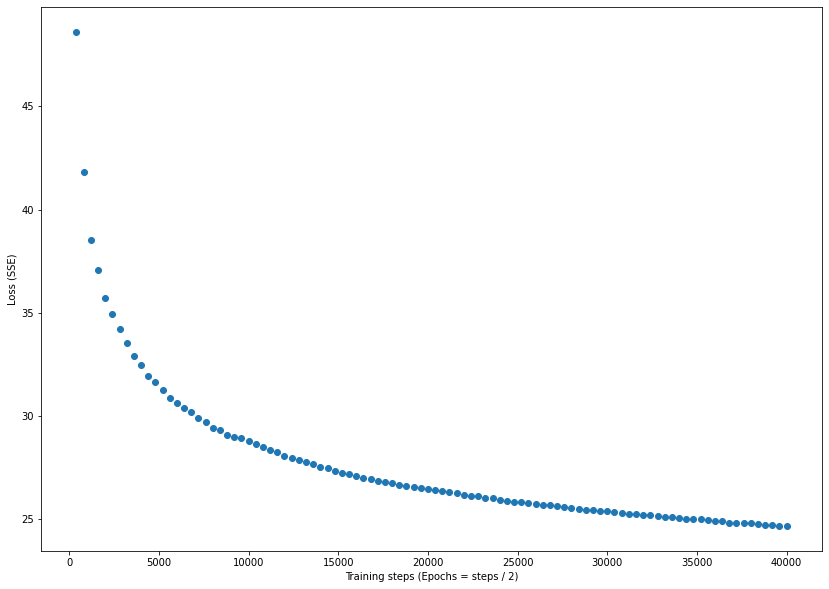

In [28]:
# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 5)')
plt.ylabel('Loss (SSE)')
plt.show()

In [31]:
pred = regressor.predict(input_fn=wx_input_fn(Xtest,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error

print("The Explained Variance: %.2f" % explained_variance_score(
                                            ytest, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            ytest, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            ytest, predictions))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.89
The Mean Absolute Error: 3.48 degrees Celcius
The Median Absolute Error: 2.76 degrees Celcius


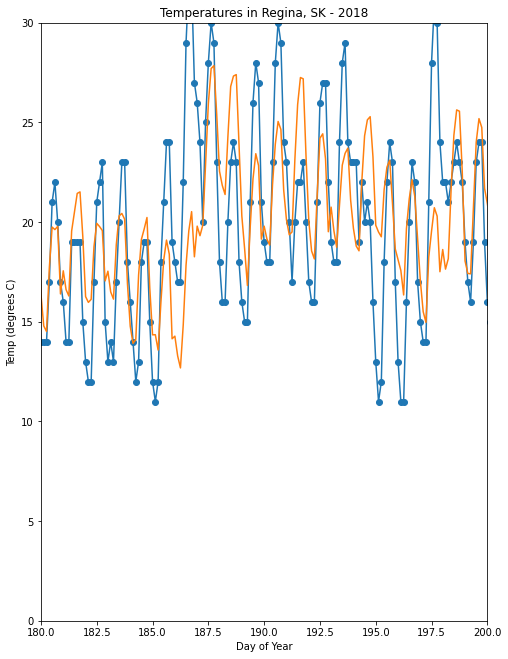

In [38]:
x = Xtest['date_delta']

df_final = pd.DataFrame({'x':x, 'yData':ytest, 'yFit': predictions, 'Residual': ytest-predictions})
df_final = df_final.sort_values(by=['x'])

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData'],'o-')
axs2.set_ylabel('Temp (degrees C)')
axs2.set_xlabel('Day of Year')
axs2.set_title('Temperatures in Regina, SK - 2018')
axs2.set_xlim(180,200)
axs2.set_ylim(0,30)
axs2.plot(df_final['x'],df_final['yFit'])

plt.show()


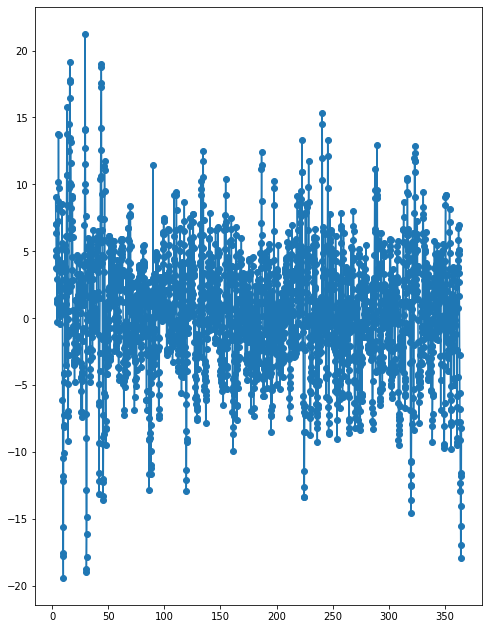

In [33]:
fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData']-df_final['yFit'],'o-')

(array([  2.,   1.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,   2.,   0.,
          2.,   0.,   1.,   4.,   4.,   5.,   5.,   5.,   5.,   2.,   2.,
          2.,   4.,  11.,  11.,  11.,  16.,  20.,  25.,  26.,  26.,  24.,
         38.,  32.,  38.,  54.,  60.,  56.,  66.,  64.,  90.,  85.,  98.,
         99., 114., 106., 134., 129., 113., 147.,  92., 105.,  87.,  84.,
        113.,  81.,  70.,  70.,  67.,  55.,  58.,  41.,  40.,  29.,  14.,
         19.,  11.,  13.,  11.,  15.,  11.,   5.,   9.,   5.,   5.,   7.,
          3.,   5.,   3.,   4.,   3.,   3.,   2.,   0.,   1.,   1.,   0.,
          1.,   0.,   2.,   2.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,
          1.]), array([-19.39511657, -18.98877645, -18.58243633, -18.17609621,
        -17.76975609, -17.36341597, -16.95707585, -16.55073573,
        -16.14439561, -15.73805549, -15.33171537, -14.92537525,
        -14.51903513, -14.11269501, -13.70635489, -13.30001477,
        -12.89367465, -12.48733453, -12.08099441, -11.67465429,

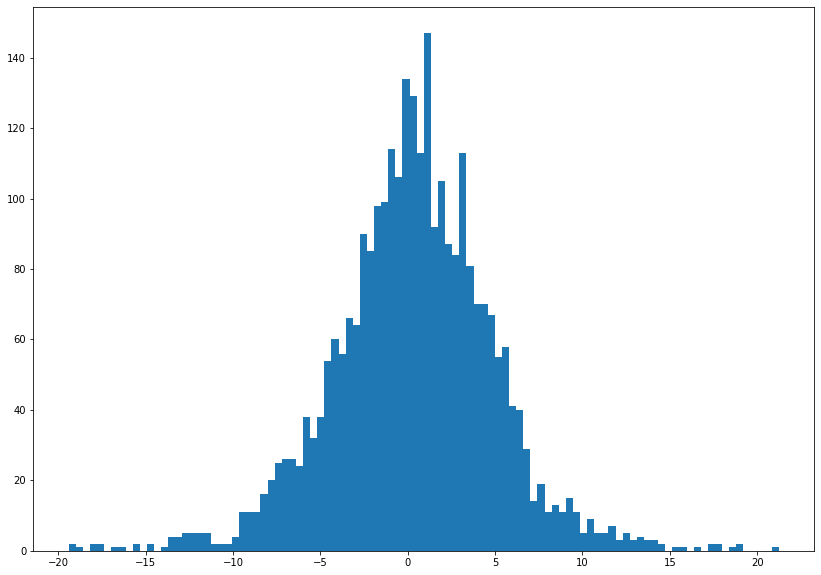

In [34]:
plt.hist(df_final['yData']-df_final['yFit'],bins=100)

0.35229923826907966 4.6007150772841605


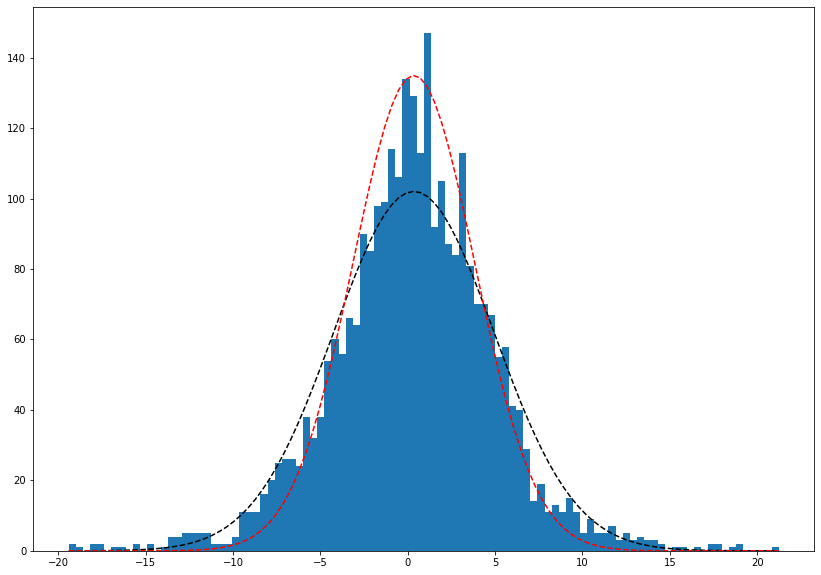

In [35]:
# best fit of data
data = df_final['yData']-df_final['yFit']
(mu, sigma) = stats.norm.fit(data)
print (mu,sigma)

# Empirical average and variance are computed
nbins = 100
avg = mu
var = sigma**2
N = len(df_final)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(data),np.max(data),nbins)
bin_size = (np.max(data) - np.min(data))/nbins
pdf_y = N*bin_size/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

var_mean = (mean_absolute_error(ytest, predictions)**2)
pdf_y2 = N*bin_size/np.sqrt(2*np.pi*var_mean)*np.exp(-0.5*(pdf_x-avg)**2/var_mean)

plt.hist(data,bins=100)
plt.plot(pdf_x,pdf_y,'k--')
plt.plot(pdf_x,pdf_y2,'r--')
plt.show()